# Comparision between linear and non-linear classifier in quantification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import baycomp as bc
import glob
import os
from tqdm import tqdm

## Load results

In [2]:
results = pd.read_csv("results_nonlinear_geometric_clf_1000bags.csv")
results.truth = results.truth.round()

## Summaries

In [3]:
mae_results = results.groupby(['method'])[['mae']].agg(['mean', 'median'])
mae_results

mae          
            mean    median
method                    
AC      0.056770  0.030925
CvMy    0.063925  0.040533
EDX     0.051568  0.033494
EDy     0.053232  0.031869
HDX     0.061574  0.036032
HDy     0.054496  0.027857

In [4]:
results.groupby(['dataset', 'method'])[['mae']].agg(["mean", "median"]).unstack()

mae                                          \
                        mean                                           
method                    AC      CvMy       EDX       EDy       HDX   
dataset                                                                
acute.a             0.003443  0.078870  0.036789  0.034158  0.037436   
acute.b             0.031244  0.085990  0.044307  0.049244  0.016908   
balance.1           0.027288  0.024825  0.018339  0.020380  0.020198   
balance.3           0.056061  0.073685  0.033433  0.065865  0.039040   
breast-cancer       0.020384  0.013943  0.007920  0.008653  0.012203   
cmc.1               0.075096  0.059858  0.079180  0.053722  0.083704   
cmc.2               0.045461  0.044392  0.031589  0.039898  0.053901   
cmc.3               0.054448  0.074532  0.131292  0.069859  0.118136   
coil                0.110429  0.257460  0.053208  0.254472  0.129702   
ctg.1               0.009849  0.016915  0.033315  0.008948  0.045826   
ctg.2               0.013870  0.016594  0.013777  0.013815  0.019358   
ctg.3               0.010178  0.021812  0.024779  0.020732  0.035677   
default_credit      0.010151  0.017968  0.009869  0.010646  0.012447   
diabetes            0.073491  0.030707  0.035709  0.030168  0.047023   
german              0.061185  0.049848  0.117644  0.050841  0.125313   
haberman            0.165660  0.162789  0.096395  0.144296  0.301881   
ionosphere          0.034407  0.031137  0.038821  0.021449  0.036510   
iris.1              0.002795  0.056957  0.014571  0.011620  0.022059   
iris.2              0.044276  0.076278  0.083632  0.059911  0.044400   
iris.3              0.021065  0.095049  0.096056  0.047522  0.046613   
lettersH            0.007219  0.011222  0.005005  0.007194  0.033488   
mammographic        0.055272  0.045912  0.024464  0.035209  0.025843   
normtrans           0.110249  0.073776  0.054388  0.065312  0.181193   
normwine.1          0.012549  0.052290  0.032801  0.023854  0.021305   
normwine.2          0.100594  0.044131  0.054215  0.030117  0.023940   
normwine.3          0.023776  0.039539  0.027417  0.029780  0.037610   
pageblocks.5        0.110912  0.037596  0.014847  0.038754  0.034736   
phoneme             0.008332  0.017695  0.018081  0.011335  0.008827   
semeion.8           0.074460  0.033870  0.125921  0.037883  0.088174   
sonar               0.178017  0.092078  0.121383  0.089349  0.127089   
spambase            0.016968  0.029450  0.005902  0.024869  0.011752   
spectf              0.161432  0.324876  0.225197  0.303847  0.168973   
tictactoe           0.042479  0.086191  0.069644  0.088051  0.102702   
transfusion         0.277212  0.101092  0.048984  0.112885  0.092668   
wdbc                0.038408  0.040330  0.012893  0.038297  0.016054   
wine-quality-red    0.071980  0.057152  0.050342  0.056032  0.044165   
wine-quality-white  0.025965  0.018992  0.018842  0.019023  0.018972   
wine.1              0.021231  0.061783  0.050063  0.027385  0.042958   
wine.2              0.086668  0.076728  0.056198  0.058450  0.041359   
wine.3              0.007354  0.058761  0.040579  0.040350  0.047930   
yeast               0.025711  0.027837  0.056478  0.028334  0.106467   

                                                                      \
                                median                                 
method                   HDy        AC      CvMy       EDX       EDy   
dataset                                                                
acute.a             0.040241  0.003081  0.070555  0.033128  0.030036   
acute.b             0.061967  0.031363  0.085288  0.043410  0.050520   
balance.1           0.020555  0.023611  0.021115  0.015250  0.017360   
balance.3           0.050280  0.054989  0.072403  0.029795  0.065650   
breast-cancer       0.016061  0.019858  0.011805  0.006619  0.007389   
cmc.1               0.032163  0.071939  0.058201  0.073221  0.050967   
cmc.2               0.124383  0.038161  0.037158  0.027884  0.03

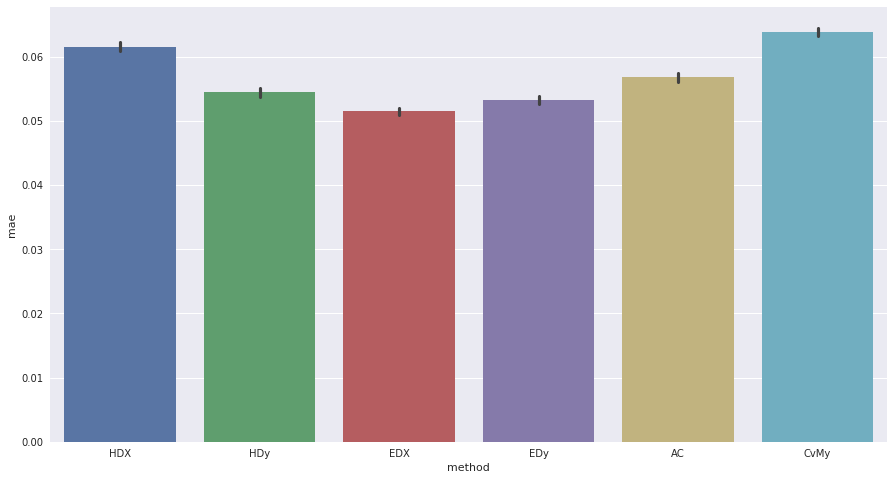

In [5]:
_, ax = plt.subplots(1,1,figsize=(15, 8))
sns.barplot(x="method", y="mae", data=results, 
            #order=["AC_linear", "AC_nonlinear", "AC_nonlinear_geometric", "EDX", "EDy_linear", "EDy_nonlinear", 
            #       "EDy_nonlinear_geometric", "HDX", "HDy_linear", "HDy_nonlinear", "HDy_nonlinear_geometric"]
           )

## Baycomp

In [6]:
from baycomp.utils import import_plt
from math import sqrt, sin, cos, pi

def plot_simplex(test, ax, names=None):
    """
    Plot the posterior distribution in a simplex.

    The distribution is shown as a triangle with regions corresponding to
    first classifier having higher scores than the other by more than rope,
    the second having higher scores, or the difference being within the
    rope.

    Args:
        names (tuple of str): names of classifiers
    """

    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    def project(points):
        p1, p2, p3 = points.T / sqrt(3)
        x = (p2 - p1) * cos(pi / 6) + 0.5
        y = p3 - (p1 + p2) * sin(pi / 6) + 1 / (2 * sqrt(3))
        return np.vstack((x, y)).T

    ax.set_aspect('equal', 'box')

    # triangle
    ax.add_line(Line2D([0, 0.5, 1.0, 0],
                       [0, np.sqrt(3) / 2, 0, 0], color='orange'))
    names = names or test.names or ("C1", "C2")
    pl, pe, pr = test.probs()
    ax.text(0, -0.04,
            'p({}) = {:.3f}'.format(names[0], pl),
            horizontalalignment='center', verticalalignment='top')
    ax.text(0.5, np.sqrt(3) / 2,
            'p(rope) = {:.3f}'.format(pe),
            horizontalalignment='center', verticalalignment='bottom')
    ax.text(1, -0.04,
            'p({}) = {:.3f}'.format(names[1], pr),
            horizontalalignment='center', verticalalignment='top')
    cx, cy = project(np.array([[0.3333, 0.3333, 0.3333]]))[0]
    for x, y in project(np.array([[.5, .5, 0], [.5, 0, .5], [0, .5, .5]])):
        ax.add_line(Line2D([cx, x], [cy, y], color='orange'))

    # project and draw points
    tripts = project(test.sample[:, [0, 2, 1]])
    ax.hexbin(tripts[:, 0], tripts[:, 1], mincnt=1, cmap=plt.cm.Blues_r)
    # Leave some padding around the triangle for vertex labels
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.2, 1.2)
    ax.axis('off')

# Hierarchical Test

/usr/local/lib/python3.5/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


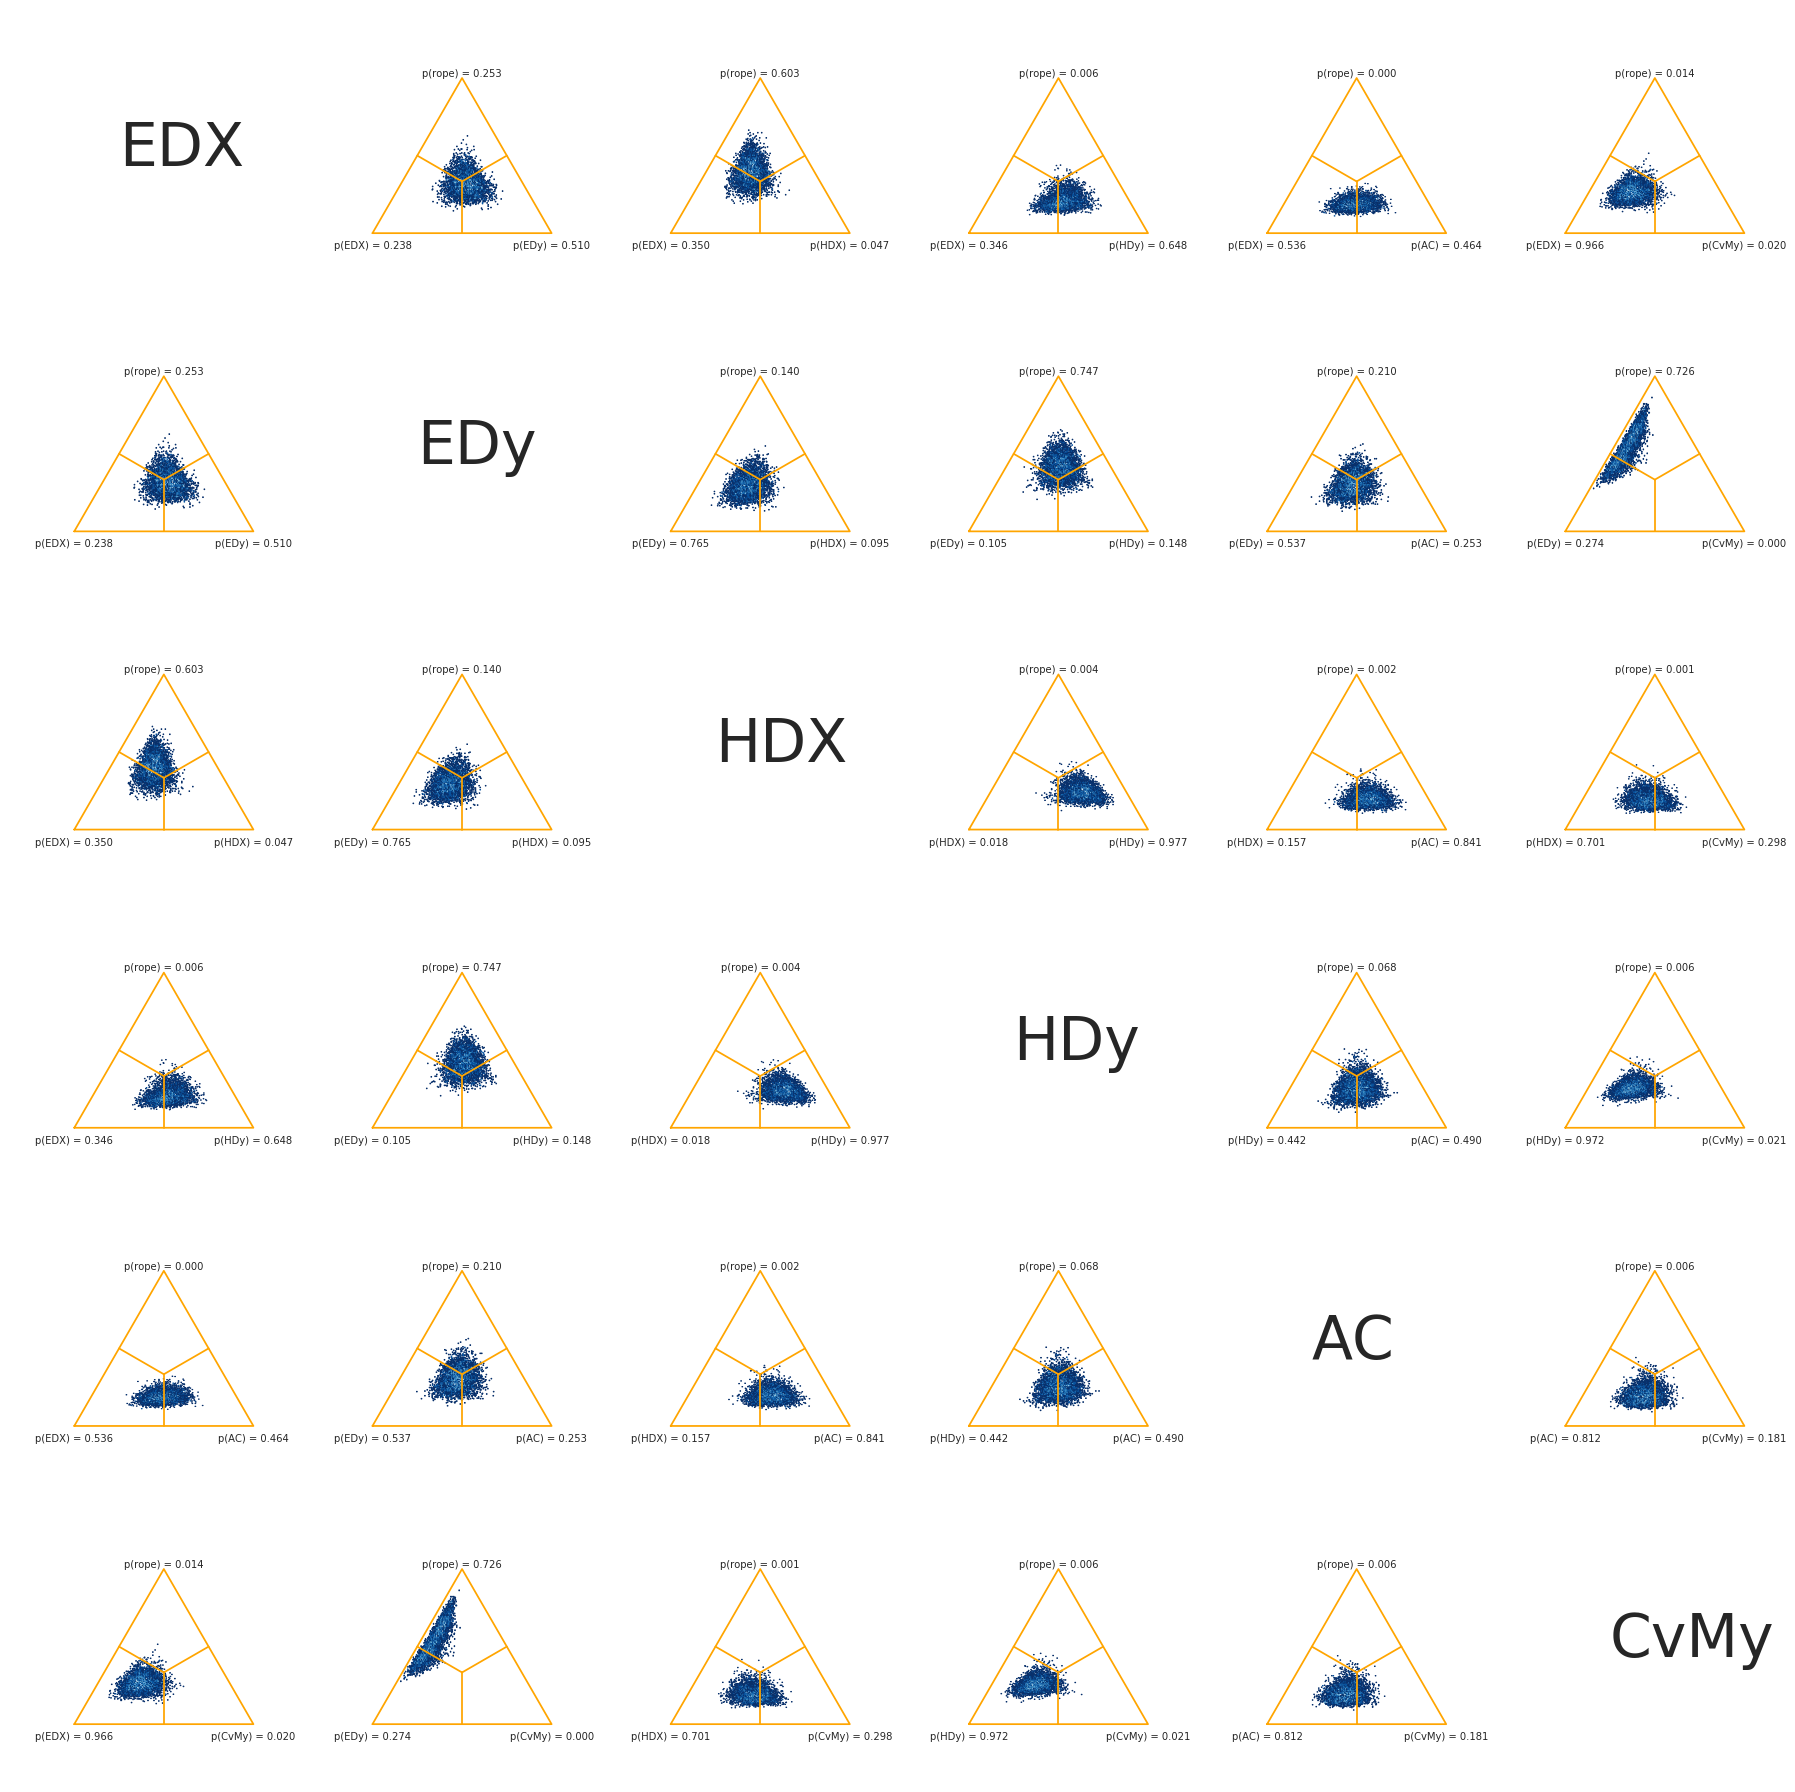

In [9]:
def get_data(method, aggregate=False):
    results = pd.read_csv("results_nonlinear_geometric_clf_1000bags.csv")

    results = results[results.method == method].sort_values("dataset")
    maes = results["mae"].values.reshape(41, -1)
    if aggregate:
        maes = maes.mean(axis=1)

    inv_maes = 1 - maes
    return inv_maes

from matplotlib.transforms import Bbox

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

prob_df = pd.DataFrame(columns=["Cuantificador1", "Cuantificador2", "p(m1)", "p(rope)", "p(m2)"])

methods = ["EDX", "EDy", "HDX", "HDy", "AC", "CvMy"]

methods_combs = combinations(methods, 2)

fig, axs = plt.subplots(len(methods), len(methods), figsize=(25, 25))
_ = [axs[i][i].axis("off") for i in range(len(methods))]
_ = [axs[i][i].text(0.32, 0.42, methods[i], fontsize=60) for i in range(len(methods))]
for m1, m2 in methods_combs:
    i, j = methods.index(m1), methods.index(m2)
    try:
        data_hdx = get_data(m1)
        data_hdy = get_data(m2)

        test = bc.HierarchicalTest(data_hdx, data_hdy, 0.01, runs=1)
        plot_simplex(test, axs[i][j], names=(m1, m2))
        plot_simplex(test, axs[j][i], names=(m1, m2))
        extent = full_extent(axs[i][j]).transformed(fig.dpi_scale_trans.inverted())
        fig.savefig("figures/Hierarchical_{}_vs_{}.png".format(m1, m2), bbox_inches=extent)
    except RuntimeError as err:
        print("Failed Hierarchical Test between ", m1, m2, err)
        
    prob_df = prob_df.append(pd.DataFrame([[m1, m2] + list(test.probs())], columns=["Cuantificador1", "Cuantificador2", "p(m1)", "p(rope)", "p(m2)"]))

fig.tight_layout()

# Sign Test

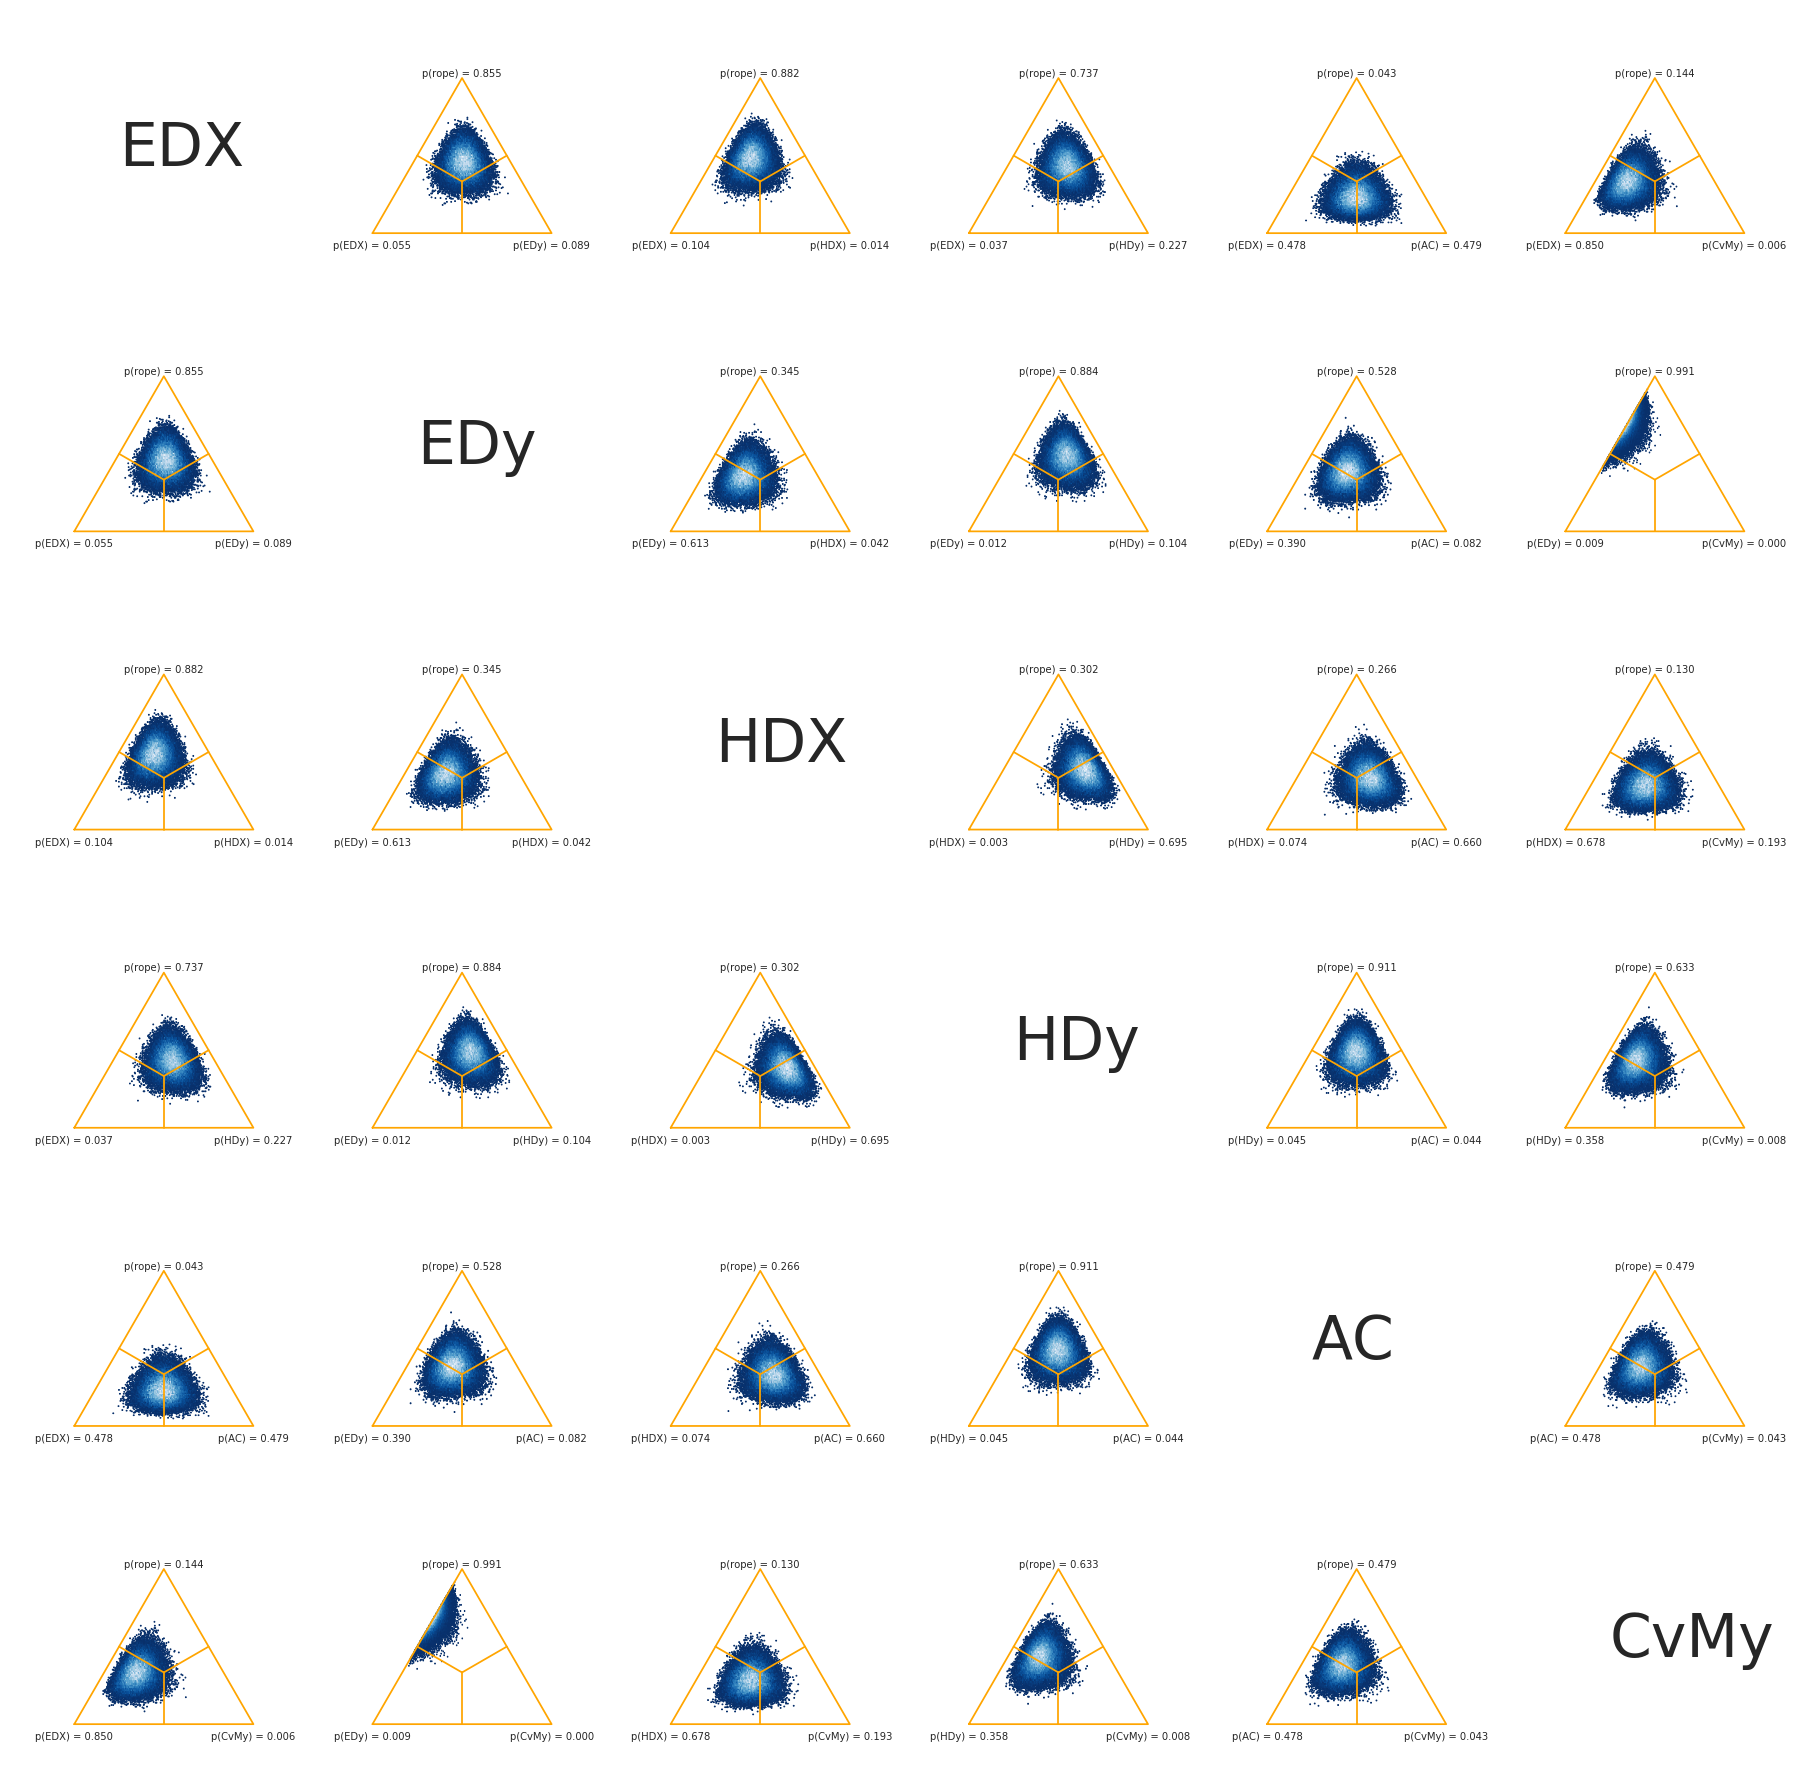

In [38]:
fig, axs = plt.subplots(len(methods), len(methods), figsize=(25, 25))
_ = [axs[i][i].axis("off") for i in range(len(methods))]
_ = [axs[i][i].text(0.32, 0.42, methods[i], fontsize=60) for i in range(len(methods))]

methods_combs = combinations(methods, 2)

for m1, m2 in methods_combs:
    i, j = methods.index(m1), methods.index(m2)
    try:
        data_hdx = get_data(m1, aggregate=True)
        data_hdy = get_data(m2, aggregate=True)

        test = bc.SignTest(data_hdx, data_hdy, 0.01)
        plot_simplex(test, axs[i][j], names=(m1, m2))
        plot_simplex(test, axs[j][i], names=(m1, m2))
    except RuntimeError as err:
        print("Failed Signed Test between ", m1, m2, err)
    
    plt.savefig("figures/Signed_1000bags.png".format(m1, m2))

fig.tight_layout()

In [ ]:
def get_data_one_ds(method, dataset, aggregate=False):
    results = pd.read_csv("results_nonlinear_geometric_clf_1000bags.csv")

    results = results[np.logical_and(results.method == method, results.dataset == dataset)]
    maes = results["mae"].values

    if aggregate:
        maes = maes.mean(axis=1)

    inv_maes = 1 - maes
    return inv_maes

datasets_dir = "datasets"
dataset_files = [file for file in glob.glob(os.path.join(datasets_dir, "*.csv")) if file not in ["datasets/balance.2.csv", "datasets/lettersG.csv", "datasets/k9.csv"]]
dataset_names = [os.path.split(name)[-1][:-4] for name in dataset_files]

In [ ]:
methods = ["EDX", "EDy", "HDX", "HDy", "AC", "CvMy"]

methods_combs = combinations(methods, 2)
two_on_single_df = pd.DataFrame(columns=["Cuantificador1", "Cuantificador2", "Dataset", "p(m1)", "p(rope)", "p(m2)"])

for m1, m2 in tqdm(methods_combs):
    for dname in dataset_names:
        data1 = get_data_one_ds(m1, dname)
        data2 = get_data_one_ds(m2, dname)
        test = bc.two_on_single(data1, data2, rope=0.01)
        two_on_single_df = two_on_single_df.append(pd.DataFrame([[m1, m2, dname] + list(test)], columns=["Cuantificador1", "Cuantificador2", "Dataset", "p(m1)", "p(rope)", "p(m2)"]))
two_on_single_df["Par"] = two_on_single_df.Cuantificador1 + "-" + two_on_single_df.Cuantificador2

In [ ]:
two_on_single_df[["n(m1)", "n(rope)", "n(m2)"]] = (two_on_single_df[["p(m1)", "p(rope)", "p(m2)"]] > 0.95)
final_df = two_on_single_df.groupby("Par").sum()[["n(m1)", "n(rope)", "n(m2)"]]
final_df["n(no_decision)"] = 41 - final_df["n(m1)"] - final_df["n(m2)"] - final_df["n(rope)"]
final_df.sum() / 615

In [ ]:
data1 = get_data_one_ds("EDX", "coil")
data2 = get_data_one_ds("EDy", "coil")
test = bc.two_on_single(data1, data2, rope=0.01, plot=True)

In [13]:
fig.savefig("figures/Hierarchical_1000bags.png")

In [37]:
print(prob_df.to_latex(index=None))

\begin{tabular}{llrrr}
\toprule
Cuantificador1 & Cuantificador2 &    p(m1) &  p(rope) &    p(m2) \\
\midrule
           EDX &            EDy &  0.23775 &  0.25250 &  0.50975 \\
           EDX &            HDX &  0.34975 &  0.60325 &  0.04700 \\
           EDX &            HDy &  0.34575 &  0.00575 &  0.64850 \\
           EDX &             AC &  0.53575 &  0.00000 &  0.46425 \\
           EDX &           CvMy &  0.96575 &  0.01400 &  0.02025 \\
           EDy &            HDX &  0.76525 &  0.13950 &  0.09525 \\
           EDy &            HDy &  0.10500 &  0.74725 &  0.14775 \\
           EDy &             AC &  0.53725 &  0.21000 &  0.25275 \\
           EDy &           CvMy &  0.27425 &  0.72575 &  0.00000 \\
           HDX &            HDy &  0.01850 &  0.00425 &  0.97725 \\
           HDX &             AC &  0.15700 &  0.00175 &  0.84125 \\
           HDX &           CvMy &  0.70100 &  0.00125 &  0.29775 \\
           HDy &             AC &  0.44175 &  0.06775 &  0.49050 \\
       